# Add libs


In [1]:
import random
import string
import numpy as np
import tensorflow as tf
import pandas as pd

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare data

In [117]:
mergeddata = pd.read_csv("datamerge.csv")
mergeddata = mergeddata[["latitude","longitude","address","zip","city","mappage"]]
mergeddata = mergeddata.drop_duplicates().fillna(0).reset_index(drop="True")
n = mergeddata.shape[0]-1

mergeddata.mappage = pd.to_numeric(mergeddata.mappage, errors='coerce').fillna(-100)





# Set up Tensorflow


In [118]:
sess = tf.Session()
test_address = tf.sparse_placeholder( dtype=tf.string)
test_city = tf.sparse_placeholder( dtype=tf.string)
test_zip = tf.placeholder(shape=[None, 1], dtype=tf.float32)
test_mappage = tf.placeholder(shape=[None, 1], dtype=tf.float32)
ref_address = tf.sparse_placeholder(dtype=tf.string)
ref_city = tf.sparse_placeholder(dtype=tf.string)
ref_zip = tf.placeholder(shape=[None, n], dtype=tf.float32)
ref_mappage = tf.placeholder(shape=[None, n], dtype=tf.float32)                          

# Distances


In [121]:
zip_dist = tf.square(tf.subtract(ref_zip, test_zip))
mappage_dist = tf.square(tf.subtract(ref_mappage, test_mappage))
address_dist = tf.edit_distance(test_address, ref_address, normalize=True)
city_dist = tf.edit_distance(test_city, ref_city, normalize=True)

# Similarities

In [122]:
zip_max = tf.gather(tf.squeeze(zip_dist), tf.argmax(zip_dist, 1))
zip_min = tf.gather(tf.squeeze(zip_dist), tf.argmin(zip_dist, 1))
zip_sim = tf.div(tf.subtract(zip_max, zip_dist), tf.subtract(zip_max, zip_min))

mappage_max = tf.gather(tf.squeeze(mappage_dist), tf.argmax(mappage_dist, 1))
mappage_min = tf.gather(tf.squeeze(mappage_dist), tf.argmin(mappage_dist, 1))
mappage_sim = tf.div(tf.subtract(mappage_max, mappage_dist), tf.subtract(mappage_max, mappage_min))


address_sim = tf.subtract(1., address_dist)
city_sim = tf.subtract(1., city_dist)

# Weights

In [123]:
address_weight = 0.2
city_weight = 0.3
mappage_weight = 0.2
zip_weight = 1. - (address_weight + city_weight + mappage_weight)

weighted_sim1 = tf.add(tf.transpose(tf.multiply(address_weight, address_sim)),
                      tf.multiply(zip_weight, zip_sim))
                      
weighted_sim2 = tf.add(tf.transpose(tf.multiply(city_weight, city_sim)),
                      weighted_sim1)

weighted_sim = tf.add(tf.multiply(zip_weight, zip_sim),
                      weighted_sim2)



top_match_index = tf.argmax(weighted_sim2, 1)

# MISC

In [124]:
def sparse_from_word_vec(word_vec):
    num_words = len(word_vec)
    indices = [[xi, 0, yi] for xi,x in enumerate(word_vec) for yi,y in enumerate(x)]
    chars = list(''.join(word_vec))
    # Now we return our sparse vector
    return(tf.SparseTensorValue(indices, chars, [num_words,1,1]))

def getTestSet(testNumber, maxN):
    # test 
    test = {}
    test["address"] = mergeddata.address[testNumber] 
    test["zip"] = mergeddata.zip[testNumber]
    test["city"] = mergeddata.city[testNumber]
    test["latitude"] = mergeddata.latitude[testNumber] 
    test["longitude"] = mergeddata.longitude[testNumber]
    test["mappage"] = mergeddata.mappage[testNumber]

    # ref
    ref = {}
    ref["address"] = list(mergeddata.address[:testNumber]) + list((mergeddata.address[(testNumber+1):maxN])) 
    ref["zip"] = list(mergeddata.zip[:testNumber]) + list((mergeddata.zip[(testNumber+1):maxN]))
    ref["city"] = list(mergeddata.city[:testNumber]) + list((mergeddata.city[(testNumber+1):maxN]))
    ref["latitude"] = list(mergeddata.latitude[:testNumber]) + list((mergeddata.latitude[(testNumber+1):maxN]))
    ref["longitude"] = list(mergeddata.longitude[:testNumber]) + list((mergeddata.longitude[(testNumber+1):maxN]))   
    ref["mappage"] = list(mergeddata.mappage[:testNumber]) + list((mergeddata.mappage[(testNumber+1):maxN]))
    
    return (test, ref)

def customDistance(test_lat, test_long, ref_lat, ref_long):
    diff_lat = abs(float(test_lat) - float(ref_lat))
    diff_long = abs(float(test_long) - float(ref_long))
    return ( (diff_lat + diff_long)/2.0 )

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


# Run Tensorflow

In [126]:

scores = []

for i in range(200):
    test, ref = getTestSet(i, n+1)

    reference_addresses = ref["address"]
    reference_zips = np.array([ref["zip"]])
    reference_mappages = np.array([ref["mappage"]])
    reference_cities = ref["city"]
    
    print len(ref["zip"])
    sparse_ref_set = sparse_from_word_vec(reference_addresses)
    sparse_ref_cities = sparse_from_word_vec(reference_cities)
    test_address_entry = test["address"]
    test_zip_entry = [[test["zip"]]]
    test_mappage_entry = [[test["mappage"]]]
    test_city_entry = test["city"]

    # Create sparse address vectors
    test_address_repeated = [test_address_entry] * n
    sparse_test_set = sparse_from_word_vec(test_address_repeated)
    test_city_repeated = [test_city_entry] * n
    sparse_test_city = sparse_from_word_vec(test_city_repeated)

    feeddict={test_address: sparse_test_set,
               test_zip: test_zip_entry,
               test_mappage: test_mappage_entry,
               test_city: sparse_test_city,
               ref_address: sparse_ref_set,
               ref_zip: reference_zips,
               ref_mappage: reference_mappages,
               ref_city: sparse_ref_cities}
    best_match = sess.run(top_match_index, feed_dict=feeddict)
    best_street = reference_addresses[int(best_match)]
    best_city = reference_cities[int(best_match)]
    [best_zip] = reference_zips[0][best_match]
    [[test_zip_]] = test_zip_entry
    print('Address: ' + str(test_city_entry) + "," + str(test_address_entry) + ', ' + str(test_zip_)) + ', ' + str(test["latitude"])
    print('Match  : ' + str(best_city) + ','+ str(best_street) + ','  + str(best_zip))+ ', ' + str(ref["latitude"][int(best_match)])
    scores.append( haversine(test["longitude"],
                         test["latitude"],
                         ref["longitude"][int(best_match)],
                         ref["latitude"][int(best_match)]))
                     
print "%s: %s ± %s"%("neg_mean_absolute_error (km)", round(np.mean(scores),4), round(np.std(scores),4))

                     

4292
Address: SAN DIEGO,17725 BELLECHASE CIR, 92128, 33.03666
Match  : SAN DIEGO,17705 BELLECHASE CIRCLE,92128, 33.03666
4292
Address: ESCONDIDO,304 HIDDEN TRAILS RD, 92027, 33.14431
Match  : ESCONDIDO,304 HIDDEN TRAILS RD,92027, 33.14431
4292
Address: ESCONDIDO,304 HIDDEN TRAILS RD, 92027, 33.14431
Match  : ESCONDIDO,304 HIDDEN TRAILS RD,92027, 33.14431
4292
Address: SAN DIEGO,1876 ELM AVE., 92154, 32.58095
Match  : SAN DIEGO,4066 PALM AVE,92154, 32.58401
4292
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71008
Match  : SAN DIEGO,877 ISLAND AVE,92101, 32.71011
4292
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71011
Match  : SAN DIEGO,877 ISLAND AVE,92101, 32.71008
4292
Address: LA MESA,5700 BALTIMORE, 91942, 32.78366
Match  : LA MESA,5700 BALTIMORE,91942, 32.78451
4292
Address: LA MESA,5700 BALTIMORE, 91942, 32.78451
Match  : LA MESA,5700 BALTIMORE,91942, 32.78366
4292
Address: LA MESA,5700 BALTIMORE, 91942, 32.784420000000004
Match  : LA MESA,5700 BALTIMORE,91942, 32.78366
4292
Addres

Address: SAN DIEGO,10628 CAMINITO DERECHO, 92126, 32.91176
Match  : SAN DIEGO,10325 CAMINITO CUERVO,92108, 32.78735
4292
Address: ESCONDIDO,2135 E VALLEY PKWY, 92027, 33.1374
Match  : ESCONDIDO,2700 E VALLEY PKWY,92027, 33.14543
4292
Address: SAN DIEGO,8756 TWIN TRAILS, 92129, 32.96546
Match  : SAN DIEGO,7955 CAMINO TRANQUILO,92122, 32.86165
4292
Address: CHULA VISTA,989 PASEO LA CRESTA, 91910, 32.62634
Match  : CHULA VISTA,1029 PASEO ENTRADA,91910, 32.62747
4292
Address: LA MESA,5750 AMAYA, 91942, 32.78633
Match  : LA MESA,5750 AMAYA DR,91942, 32.78633
4292
Address: BONITA,5817 BLACKSMITH, 91902, 32.66707
Match  : BONITA,3111 CASA BONITA,91902, 32.67739
4292
Address: SPRING VALLEY,9473 DATE ST, 91977, 32.719840000000005
Match  : SPRING VALLEY,9511 LAMAR ST,91977, 32.73932
4292
Address: OCEANSIDE,2929 FIRE MOUNTAIN DRIVE, 92054, 33.19233
Match  : OCEANSIDE,4707 CRESCENT HEIGHTS DRIVE,92056, 33.22003
4292
Address: VALLEY CENTER,32776 VIA DEL VENADO, 92082, 33.30959
Match  : VALLEY CENTE

Address: CHULA VISTA,285 MOSS, 91911, 32.61658
Match  : CHULA VISTA,285 MOSS,91911, 32.61658
4292
Address: CHULA VISTA,285 MOSS, 91911, 32.61697
Match  : CHULA VISTA,285 MOSS,91911, 32.61658
4292
Address: CHULA VISTA,285 MOSS, 91911, 32.61697
Match  : CHULA VISTA,285 MOSS,91911, 32.61658
4292
Address: CHULA VISTA,285 MOSS, 91911, 32.61703
Match  : CHULA VISTA,285 MOSS,91911, 32.61658
4292
Address: CHULA VISTA,285 MOSS, 91911, 32.61703
Match  : CHULA VISTA,285 MOSS,91911, 32.61658
4292
Address: CHULA VISTA,285 MOSS, 91911, 32.61649
Match  : CHULA VISTA,285 MOSS,91911, 32.61658
4292
Address: CHULA VISTA,285 MOSS, 91911, 32.61649
Match  : CHULA VISTA,285 MOSS,91911, 32.61658
4292
Address: SPRING VALLEY,3240 S BARCELONA, 91977, 32.73953
Match  : SPRING VALLEY,2535 S BARCELONA,91977, 32.73232
4292
Address: SAN DIEGO,8953 HAMPE, 92129, 32.972120000000004
Match  : SAN DIEGO,8888 HAMPE,92129, 32.97285
4292
Address: ESCONDIDO,571 SHADYWOOD, 92026, 33.16148
Match  : ESCONDIDO,576 SHADYWOOD  DR,9

In [127]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Text(0.5,1,'Error distribution')

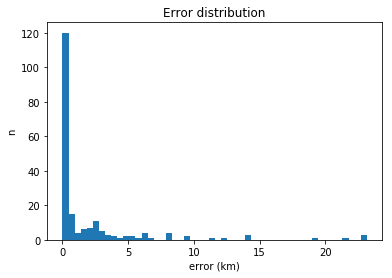

In [136]:
plt.hist(scores,50)
plt.xlabel('error (km)')
plt.ylabel('n')
plt.title('Error distribution')

# Batch mode


In [144]:
scores = []

# change datamerge.csv to your input file
batchinput = pd.read_csv("datamerge.csv")
batchinput = batchinput[["latitude","longitude","address","zip","city","mappage"]]
batchinput = batchinput.drop_duplicates().fillna(0).reset_index(drop="True")
batchinput.mappage = pd.to_numeric(batchinput.mappage, errors='coerce').fillna(-100)

# comment if test has been working
for i in range(10):
# uncomment for full run - may take some time    
#for i in range(batchinput.shape[0]):    
    test, ref = getTestSet(i, n+1)

    reference_addresses = ref["address"]
    reference_zips = np.array([ref["zip"]])
    reference_mappages = np.array([ref["mappage"]])
    reference_cities = ref["city"]
    
    print ("----")
    sparse_ref_set = sparse_from_word_vec(reference_addresses)
    sparse_ref_cities = sparse_from_word_vec(reference_cities)
    test_address_entry = batchinput.address[i]
    test_zip_entry = [[batchinput.zip[i]]]
    test_mappage_entry = [[batchinput.mappage[i]]]
    test_city_entry = batchinput.city[i]

    # Create sparse address vectors
    test_address_repeated = [test_address_entry] * n
    sparse_test_set = sparse_from_word_vec(test_address_repeated)
    test_city_repeated = [test_city_entry] * n
    sparse_test_city = sparse_from_word_vec(test_city_repeated)

    feeddict={test_address: sparse_test_set,
               test_zip: test_zip_entry,
               test_mappage: test_mappage_entry,
               test_city: sparse_test_city,
               ref_address: sparse_ref_set,
               ref_zip: reference_zips,
               ref_mappage: reference_mappages,
               ref_city: sparse_ref_cities}
    best_match = sess.run(top_match_index, feed_dict=feeddict)
    best_street = reference_addresses[int(best_match)]
    best_city = reference_cities[int(best_match)]
    [best_zip] = reference_zips[0][best_match]
    [[test_zip_]] = test_zip_entry
    print('Address: ' + str(test_city_entry) + "," + str(test_address_entry) + ', ' + str(test_zip_)) + ', ' + str(test["latitude"])
    print('Match  : ' + str(best_city) + ','+ str(best_street) + ','  + str(best_zip))+ ', ' + str(ref["latitude"][int(best_match)])
    print ("long/lat = %s, %s"%(ref["longitude"][int(best_match)], ref["latitude"][int(best_match)])
                         
)
                     


----
Address: SAN DIEGO,17725 BELLECHASE CIR, 92128, 33.03666
Match  : SAN DIEGO,17705 BELLECHASE CIRCLE,92128, 33.03666
long/lat = -117.07308, 33.03666
----
Address: ESCONDIDO,304 HIDDEN TRAILS RD, 92027, 33.14431
Match  : ESCONDIDO,304 HIDDEN TRAILS RD,92027, 33.14431
long/lat = -117.0236, 33.14431
----
Address: ESCONDIDO,304 HIDDEN TRAILS RD, 92027, 33.14431
Match  : ESCONDIDO,304 HIDDEN TRAILS RD,92027, 33.14431
long/lat = -117.0236, 33.14431
----
Address: SAN DIEGO,1876 ELM AVE., 92154, 32.58095
Match  : SAN DIEGO,4066 PALM AVE,92154, 32.58401
long/lat = -117.04617, 32.58401
----
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71008
Match  : SAN DIEGO,877 ISLAND AVE,92101, 32.71011
long/lat = -117.15687, 32.71011
----
Address: SAN DIEGO,877 ISLAND AVE, 92101, 32.71011
Match  : SAN DIEGO,877 ISLAND AVE,92101, 32.71008
long/lat = -117.15692, 32.71008
----
Address: LA MESA,5700 BALTIMORE, 91942, 32.78366
Match  : LA MESA,5700 BALTIMORE,91942, 32.78451
long/lat = -117.03453, 32.78451
---